In [1]:
import time
import requests
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
from scipy.spatial.distance import cdist
from datetime import date
from numpy import asarray
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

pd.options.mode.chained_assignment = None  # default='warn'

1. Scrape data from basketball references
    - Look at mvp voting
    - Pull individual counting and advanced stats, and team stats
    - scale stats accordingly
2. Feature selection and engineering
3. Train model off of previous year data
4. Predict MVP

## Previous MVP Data

In [171]:
mvp_df = pd.read_csv('/Users/yushunli/Documents/Data Science/NBA Projects/MVP Predictor/mvp_results_full.csv')
mvp_df = (mvp_df.groupby('Season')
                      .apply(lambda x: x.nlargest(5, 'Pts Won'))
                      .reset_index(drop=True))
mvp_df.head()

,Player,Age,Season,Tm,First,Pts Won,Pts Max,Share,G,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48
0,LeBron James,28,2013,MIA,120.0,1207.0,1210.0,0.998,76.0,37.9,26.8,8.0,7.3,1.7,0.9,0.565,0.406,0.753,19.3,0.322
1,Kevin Durant,24,2013,OKC,0.0,765.0,1210.0,0.632,81.0,38.5,28.1,7.9,4.6,1.4,1.3,0.510,0.416,0.905,18.9,0.291
2,Carmelo Anthony,28,2013,NYK,1.0,475.0,1210.0,0.393,67.0,37.0,28.7,6.9,2.6,0.8,0.5,0.449,0.379,0.830,9.5,0.184
3,Chris Paul,27,2013,LAC,0.0,289.0,1210.0,0.239,70.0,33.4,16.9,3.7,9.7,2.4,0.1,0.481,0.328,0.885,13.9,0.287
4,Kobe Bryant,34,2013,LAL,0.0,184.0,1210.0,0.152,78.0,38.6,27.3,5.6,6.0,1.4,0.3,0.463,0.324,0.839,10.9,0.174


### Train Naive Linear Regression Model

In [173]:
y = mvp_df.Share
X = mvp_df[['G', 'PTS', 'TRB', 'AST', 'FG%', 'WS/48']]

# create a LinearRegression model
model = LinearRegression()

# train the model on the data
model.fit(X, y)

# make predictions on the training set
y_pred = model.predict(X)

# calculate the mean squared error (MSE) and R-squared score for the model
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

# print the summary of the model
print("Intercept: ", model.intercept_)
print("Coefficients: ", model.coef_)
print("Mean squared error (MSE): %.2f" % mse)
print("R-squared score: %.2f" % r2)

Intercept:  -2.366553829829408
Coefficients:  [0.00837211 0.02303486 0.01692489 0.02486842 0.82720071 3.82989962]
Mean squared error (MSE): 0.03
R-squared score: 0.63


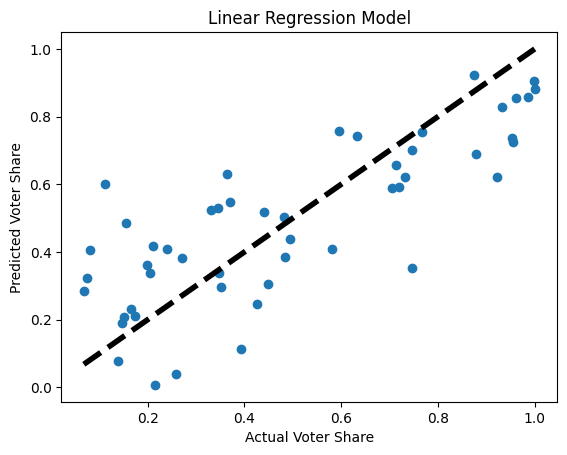

In [174]:
# create scatter plot of actual vs predicted
plt.scatter(y, y_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4) # y=x line
plt.xlabel('Actual Voter Share')
plt.ylabel('Predicted Voter Share')
plt.title('Linear Regression Model')
plt.show()

In [175]:
#Show Results of the Naive Model on the Trained Data
mvp_df_lr = mvp_df.copy()
mvp_df_lr['Pred_Share'] = y_pred
mvp_df_lr['Actual_Rank'] = mvp_df_lr.groupby('Season')['Share'].rank(ascending=False, method='dense')
mvp_df_lr['Predicted_Rank'] = mvp_df_lr.groupby('Season')['Pred_Share'].rank(ascending=False, method='dense')
mvp_df_lr = mvp_df_lr[['Player', 'Season', 'First', 'Share', 'Pred_Share', 'Actual_Rank', 'Predicted_Rank']]
mvp_df_lr.loc[(mvp_df_lr.Predicted_Rank != mvp_df_lr.Actual_Rank) & (mvp_df_lr.Predicted_Rank < 3)]

,Player,Season,First,Share,Pred_Share,Actual_Rank,Predicted_Rank
19,Kevin Durant,2016,0.0,0.112,0.600756,5.0,2.0
20,Russell Westbrook,2017,69.0,0.879,0.688674,1.0,2.0
21,James Harden,2017,22.0,0.746,0.699813,2.0,1.0
37,James Harden,2020,0.0,0.363,0.631134,3.0,2.0
43,Giannis Antetokounmpo,2021,1.0,0.345,0.529494,4.0,2.0
47,Giannis Antetokounmpo,2022,9.0,0.595,0.757329,3.0,2.0


In [6]:
#Error Ranking
def weighted_error(y_true, y_pred):
    weights = [5, 3] + [1]*(len(y_true)-2)
    rank_true = y_true.argsort().argsort() # get the rank of the true values
    rank_pred = y_pred.argsort().argsort() # get the rank of the predicted values
    error = np.sum(np.abs(rank_true - rank_pred) * weights) / np.sum(weights)
    return error

## Feature Selection & Data Engineering
- Pull Teams Stats: Team Wins
- Counting Stats: 
- Advanced Stats: 

In [44]:
def manipulate_stats(df):
    df['G'] = round(df['G']/82,2)
    df['Minutes'] = round(df['MP_x']/48,2)
    df.drop(columns = ['MP_x'], inplace = True)
    return df

In [56]:
def min_max_scale_stats(df, stats_cols):
    # Select the columns to be scaled
    stats_df = df[stats_cols]
    
    # Create the scaler object
    scaler = MinMaxScaler()
    
    # Scale the selected columns
    scaled_stats = scaler.fit_transform(stats_df)
    
    # Create a new dataframe with the scaled values
    scaled_df = pd.DataFrame(scaled_stats, columns=stats_cols)
    
    # Replace the original columns in the input dataframe with the scaled values
    df[stats_cols] = scaled_df[stats_cols].round(2)
    
    return df

In [48]:
def calculate_EXP(df):
    # Calculate 2PT_EXP
    league_avg_2p = df.groupby('Season')[['2P', '2PA']].sum()
    league_avg_2p['2P%'] = league_avg_2p['2P'] / league_avg_2p['2PA']
    df = df.join(league_avg_2p, on='Season', rsuffix='_league_avg')

    df['2PT_EXP'] = round(df['2PA'] * (df['2P%'] - df['2P%_league_avg']) * 2,2)

    # Calculate 3PT_EXP
    league_avg_3p = df.groupby('Season')[['3P', '3PA']].sum()
    league_avg_3p['3P%'] = league_avg_3p['3P'] / league_avg_3p['3PA']
    df = df.join(league_avg_3p, on='Season', rsuffix='_league_avg')

    df['3PT_EXP'] = round(df['3PA'] * (df['3P%'] - df['3P%_league_avg']) *3,2)

    # Calculate FT_EXP
    league_avg_ft = df.groupby('Season')[['FT', 'FTA']].sum()
    league_avg_ft['FT%'] = league_avg_ft['FT'] / league_avg_ft['FTA']
    df = df.join(league_avg_ft, on='Season', rsuffix='_league_avg')

    df['FT_EXP'] = round(df['FTA'] * (df['FT%'] - df['FT%_league_avg']),3)

    return df.drop(columns = ['3P_league_avg', '3PA_league_avg', '3P%_league_avg',
                      'FT_league_avg', 'FTA_league_avg', 'FT%_league_avg',
                      '2P_league_avg', '2PA_league_avg', '2P%_league_avg'])

In [241]:
def df_transform(df):
    df['Win_Contrib'] = round(df.MP_x / 48 * df.G / 82 * df['USG%']/100 * df.Wins,1)
    df.drop(columns = ['Pos', 'Age','GS', 'BPM', 'VORP', 'WS', 'ORB', 'DRB', 'ORB%', 'DRB%', 'eFG%', '3PAr', 'FTr', 'Wins',
                             'PF', 'FGA', '2PA', '3PA', 'FTA', 'WS/48','STL%','BLK%', 'FG', 'FG%',], inplace = True)
    df = manipulate_stats(df)
    stats_cols = ['3P', '3P%', '2P', '2P%', 'FT', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS']
    df = min_max_scale_stats(df, stats_cols)
    df = df.loc[df.Win_Contrib > 0]
    return df.sort_values(by = "Win_Contrib", ascending = False)

In [144]:
#Stats_Df scraped using the NBA Scraper Notebook
stats_df = pd.read_csv('/Users/yushunli/Documents/Data Science/NBA Projects/MVP Predictor/season_stats_13_22.csv')
#stats2 = calculate_EXP(stats_df)
stats_df = df_transform(stats_df)
stats_df.head()

,Player,Season,Tm,G,3P,3P%,2P,2P%,FT,FT%,...,TRB%,AST%,TOV%,USG%,OWS,DWS,OBPM,DBPM,Win_Contrib,Minutes
1861,Stephen Curry,2016,GSW,0.96,0.96,0.45,0.50,0.57,0.45,0.91,...,8.6,33.7,12.9,32.6,13.8,4.1,10.3,1.6,16.3,0.71
3166,James Harden,2019,HOU,0.95,0.91,0.37,0.59,0.53,0.95,0.88,...,10.0,39.5,14.5,40.5,11.4,3.8,9.4,1.6,15.7,0.77
733,Kevin Durant,2014,OKC,0.99,0.45,0.39,0.79,0.55,0.85,0.87,...,10.8,26.7,12.2,33.0,14.8,4.4,8.8,1.4,15.4,0.80
2620,James Harden,2018,HOU,0.88,0.70,0.37,0.53,0.53,0.85,0.86,...,8.6,45.1,15.1,36.1,11.6,3.8,8.5,1.4,15.2,0.74
295,LeBron James,2013,MIA,0.93,0.26,0.41,0.85,0.60,0.52,0.75,...,13.1,36.4,12.4,30.2,14.6,4.7,9.3,2.4,14.6,0.79


## Train New Model

In [103]:
def join_dataframes(mvp_df, stats_df):
    mvp_df = mvp_df.iloc[:, :8]
    df = mvp_df.merge(stats_df, on = ['Player','Season', 'Tm'])
    df.drop(columns = ['Pts Won', 'Pts Max'], inplace = True)
    df.dropna(inplace = True)
    df['Actual_Rank'] = df.groupby('Season')['Share'].rank(ascending=False, method='dense')
    last_col = df.columns[-1]  # Get the name of the last column
    col_to_move = df.pop(last_col)  # Remove the last column and save it to a variable
    df.insert(4, last_col, col_to_move)
    return df

In [105]:
mvp_train = join_dataframes(mvp_df, stats_df)
mvp_train.head()

,Player,Age,Season,Tm,Actual_Rank,First,Share,G,3P,3P%,...,TRB%,AST%,TOV%,USG%,OWS,DWS,OBPM,DBPM,Win_Contrib,Minutes
0,LeBron James,28,2013,MIA,1.0,120.0,0.998,0.93,0.26,0.41,...,13.1,36.4,12.4,30.2,14.6,4.7,9.3,2.4,14.6,0.79
1,Kevin Durant,24,2013,OKC,2.0,0.0,0.632,0.99,0.32,0.42,...,11.8,21.7,13.7,29.8,13.6,5.3,7.6,1.7,14.2,0.80
2,Carmelo Anthony,28,2013,NYK,3.0,1.0,0.393,0.82,0.43,0.38,...,10.8,14.1,9.3,35.6,7.5,2.0,6.0,-1.7,12.1,0.77
3,Chris Paul,27,2013,LAC,4.0,0.0,0.239,0.85,0.21,0.33,...,6.7,46.5,13.7,22.6,10.6,3.4,6.4,2.4,7.5,0.70
4,Kevin Durant,25,2014,OKC,1.0,119.0,0.986,0.99,0.45,0.39,...,10.8,26.7,12.2,33.0,14.8,4.4,8.8,1.4,15.4,0.80


In [178]:
y = mvp_train.Share
non_feature_cols = mvp_train.iloc[:, :7].columns
X = mvp_train.drop(columns = non_feature_cols)

### 1. Linear Regression

Intercept:  0.6153960876783198
Coefficients:  [-1.71790585e+00 -3.91962873e+00  5.31535787e-01 -5.23095252e+00
 -5.34891623e+00 -4.40708646e+00 -2.09445633e+00 -5.10691923e+00
  1.54629451e+00 -1.33311242e-01  3.45634875e-01 -2.91720569e+00
  1.39615388e+01 -7.68970250e-02  2.60867964e+00  2.00494723e-01
 -1.27315409e-02  1.30329536e-01  1.23567218e-01  3.01626968e-01
  2.45269411e-01 -2.46584503e-01  1.01023100e-01 -7.37555195e-02
 -2.41896982e+00]
Mean squared error (MSE): 0.01
R-squared score: 0.88


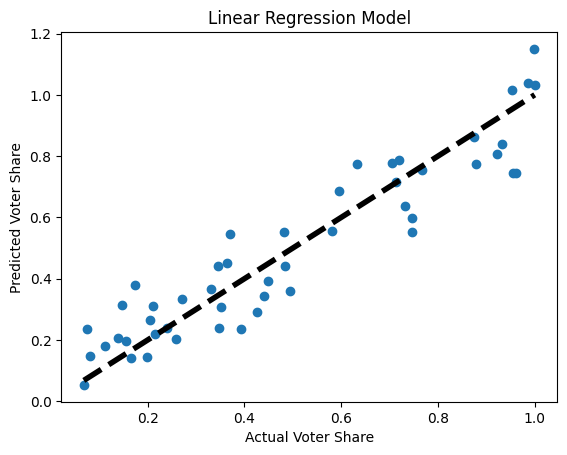

,Player,Season,Actual_Rank,Predicted_Rank
15,Kawhi Leonard,2016,2.0,4.0


In [228]:
# create a LinearRegression model
model = LinearRegression()

# train the model on the data
model.fit(X, y)

# make predictions on the training set
y_pred = model.predict(X)

# calculate the mean squared error (MSE) and R-squared score for the model
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

# print the summary of the model
print("Intercept: ", model.intercept_)
print("Coefficients: ", model.coef_)
print("Mean squared error (MSE): %.2f" % mse)
print("R-squared score: %.2f" % r2)

# create scatter plot of actual vs predicted
plt.scatter(y, y_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4) # y=x line
plt.xlabel('Actual Voter Share')
plt.ylabel('Predicted Voter Share')
plt.title('Linear Regression Model')
plt.show()

#Show Results of the Linear Regression Model
mvp2_lr = mvp_train.copy()
mvp2_lr['Pred_Share'] = y_pred
mvp2_lr['Predicted_Rank'] = mvp2_lr.groupby('Season')['Pred_Share'].rank(ascending=False, method='dense')
mvp2_lr = mvp2_lr[['Player', 'Season', 'Actual_Rank', 'Predicted_Rank']]
mvp2_lr.loc[(mvp2_lr.Predicted_Rank != mvp2_lr.Actual_Rank) & (mvp2_lr.Actual_Rank < 3)]

### 2. Ridge Regression

In [180]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
ridge = Ridge(alpha=0.5)

# Fit the model on the training data
ridge.fit(X_train, y_train)

# Predict on the test data
y_pred = ridge.predict(X_test)

# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print('Ridge Regression RMSE:', rmse)


Ridge Regression RMSE: 0.20407924190994292


In [181]:
#Show Results of the Naive Model on the Trained Data
mvp2_rr = mvp_train.copy()
mvp2_rr['Pred_Share'] = ridge.predict(X)
mvp2_rr['Predicted_Rank'] = mvp2_rr.groupby('Season')['Pred_Share'].rank(ascending=False, method='dense')
mvp2_rr = mvp2_rr[['Player', 'Season', 'Actual_Rank', 'Predicted_Rank']]
mvp2_rr.loc[(mvp2_rr.Predicted_Rank != mvp2_rr.Actual_Rank) & (mvp2_rr.Actual_Rank < 3)]

,Player,Season,Actual_Rank,Predicted_Rank
10,James Harden,2015,2.0,3.0
15,Kawhi Leonard,2016,2.0,5.0
25,LeBron James,2018,2.0,3.0
35,LeBron James,2020,2.0,3.0


### 3. XgBoost

In [176]:
def weighted_error(y_true, y_pred):
    weights = [5, 3] + [1]*(len(y_true)-2)
    rank_true = y_true.argsort().argsort() # get the rank of the true values
    rank_pred = y_pred.argsort().argsort() # get the rank of the predicted values
    error = np.sum(np.abs(rank_true - rank_pred) * weights) / np.sum(weights)
    return error

In [197]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


# Train model
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', eval_metric=weighted_error, n_estimators=1000, learning_rate=0.05)
xg_reg.fit(X_train, y_train)

# Predict on test set
y_pred = xg_reg.predict(X_test)

# Evaluate model
test_error = weighted_error(y_test.values, y_pred)
print(f"Weighted error on test data: {test_error:.3f}")

Weighted error on test data: 2.182


In [198]:
#Show Results of the Naive Model on the Trained Data
mvp2_xgb = mvp_train.copy()
mvp2_xgb['Pred_Share'] = xg_reg.predict(X)
mvp2_xgb['Predicted_Rank'] = mvp2_xgb.groupby('Season')['Pred_Share'].rank(ascending=False, method='dense')
mvp2_xgb = mvp2_xgb[['Player', 'Season', 'Actual_Rank', 'Predicted_Rank']]
mvp2_xgb.loc[mvp2_xgb.Actual_Rank != mvp2_xgb.Predicted_Rank]

,Player,Season,Actual_Rank,Predicted_Rank
10,James Harden,2015,2.0,3.0
11,LeBron James,2015,3.0,4.0
12,Russell Westbrook,2015,4.0,5.0
13,Anthony Davis,2015,5.0,2.0
44,Nikola Jokić,2022,1.0,2.0
45,Joel Embiid,2022,2.0,1.0
47,Devin Booker,2022,4.0,5.0
48,Luka Dončić,2022,5.0,4.0


In [200]:
from sklearn.model_selection import GridSearchCV, KFold

param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.5, 0.75, 1.0],
    'colsample_bytree': [0.5, 0.75, 1.0]
}

# Define the cross-validation object
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the model
model = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=-1)

# Define the grid search object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring=weighted_error)

# Fit the grid search object to the data
grid_search.fit(X, y)

# Print the best parameters and the corresponding score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

/usr/local/Cellar/jupyterlab/3.4.8_1/libexec/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/Cellar/jupyterlab/3.4.8_1/libexec/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: weighted_error() takes 2 positional arguments but 3 were given

  warnings.warn(


Best parameters:  {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'subsample': 0.5}
Best score:  nan


/usr/local/Cellar/jupyterlab/3.4.8_1/libexec/lib/python3.11/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


In [201]:
# Train model
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', eval_metric=weighted_error, n_estimators=1000, learning_rate=0.01, subsample = 0.5, 
                         colsample_bytree = 0.5, max_depth=3)
xg_reg.fit(X_train, y_train)

# Predict on test set
y_pred = xg_reg.predict(X_test)

# Evaluate model
test_error = weighted_error(y_test.values, y_pred)
print(f"Weighted error on test data: {test_error:.3f}")

Weighted error on test data: 1.091


In [202]:
#Show Results of the Tuned Model on the Trained Data
mvp2_xgb = mvp_train.copy()
mvp2_xgb['Pred_Share'] = xg_reg.predict(X)
mvp2_xgb['Predicted_Rank'] = mvp2_xgb.groupby('Season')['Pred_Share'].rank(ascending=False, method='dense')
mvp2_xgb = mvp2_xgb[['Player', 'Season', 'Actual_Rank', 'Predicted_Rank']]
mvp2_xgb.loc[mvp2_xgb.Actual_Rank != mvp2_xgb.Predicted_Rank]

,Player,Season,Actual_Rank,Predicted_Rank
11,LeBron James,2015,3.0,4.0
12,Russell Westbrook,2015,4.0,5.0
13,Anthony Davis,2015,5.0,3.0
15,Kawhi Leonard,2016,2.0,3.0
16,LeBron James,2016,3.0,2.0
45,Joel Embiid,2022,2.0,3.0
46,Giannis Antetokounmpo,2022,3.0,2.0


## 2023 Prediction

In [259]:
df_23 = pd.read_csv('2023_data')
df_23 = df_transform(df_23)
df_23 = df_23.loc[(df_23.G > 0.5) & (df_23.Minutes > 0.5)]
non_feature_cols = df_23.iloc[:, :3].columns
X_23 = df_23.drop(columns = non_feature_cols)

In [265]:
df_23

,Player,Season,Tm,G,3P,3P%,2P,2P%,FT,FT%,...,TRB%,AST%,TOV%,USG%,OWS,DWS,OBPM,DBPM,Win_Contrib,Minutes
238,Jayson Tatum,2023,BOS,0.90,0.65,0.35,0.63,0.56,0.72,0.85,...,13.0,20.9,10.4,32.7,6.2,4.3,4.8,0.7,12.9,0.77
252,Joel Embiid,2023,PHI,0.80,0.20,0.33,0.95,0.59,1.00,0.86,...,17.3,22.9,11.9,37.0,8.4,3.9,6.8,2.3,11.6,0.72
166,Giannis Antetokounmpo,2023,MIL,0.77,0.14,0.28,1.00,0.60,0.79,0.64,...,19.1,33.2,13.2,38.8,4.9,3.7,5.8,2.7,11.6,0.67
235,Jaylen Brown,2023,BOS,0.82,0.49,0.34,0.73,0.58,0.39,0.76,...,10.4,16.5,11.4,31.4,1.6,3.4,1.5,-0.2,10.9,0.75
131,Donovan Mitchell,2023,CLE,0.83,0.73,0.39,0.61,0.57,0.47,0.87,...,7.0,21.4,10.3,32.1,5.4,3.5,5.6,0.6,10.1,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,Delon Wright,2023,WAS,0.61,0.16,0.34,0.18,0.56,0.10,0.87,...,8.2,20.9,12.2,12.9,2.1,1.6,0.4,3.1,1.4,0.51
161,Gary Harris,2023,ORL,0.59,0.41,0.43,0.09,0.49,0.06,0.90,...,4.7,6.9,8.0,12.6,1.3,1.1,-1.3,0.7,1.3,0.51
207,Jakob Poeltl,2023,SAS,0.56,0.00,0.00,0.50,0.62,0.17,0.60,...,18.9,17.0,17.8,18.6,1.8,1.1,0.5,0.4,1.2,0.54
186,Isaiah Stewart,2023,DET,0.61,0.27,0.33,0.25,0.54,0.22,0.74,...,15.8,7.3,11.8,17.3,1.1,0.9,-1.0,-1.1,1.1,0.59


In [261]:
#Linear Regression Prediction
lr_23 = df_23.copy()
lr_23['Pred_Share'] = model.predict(X_23).round(2)
lr_23 = lr_23.loc[(lr_23.Win_Contrib > 5) & (lr_23.G > .6)]
lr_23['Predicted_Rank'] = lr_23['Pred_Share'].rank(ascending=False, method='dense')
lr_23 = lr_23[['Player','Win_Contrib', 'PER', 'Pred_Share', 'Predicted_Rank']]
lr_23.sort_values(by = ['Predicted_Rank'], ascending = True).head(10)

,Player,Win_Contrib,PER,Pred_Share,Predicted_Rank
463,Shai Gilgeous-Alexander,8.0,27.2,0.75,1.0
252,Joel Embiid,11.6,31.4,0.45,2.0
109,DeMar DeRozan,7.6,20.6,0.34,3.0
208,Jalen Brunson,7.7,21.2,0.30,4.0
341,Luka Dončić,8.7,28.7,0.30,4.0
225,Jaren Jackson Jr.,5.7,21.6,0.28,5.0
123,Devin Booker,6.7,22.0,0.21,6.0
131,Donovan Mitchell,10.1,22.9,0.20,7.0
399,Nikola Jokić,8.5,31.5,0.19,8.0
105,De'Aaron Fox,8.9,21.8,0.17,9.0


In [262]:
#Ridge Regression Prediction
rr_23 = df_23.copy()
rr_23['Pred_Share'] = ridge.predict(X_23).round(2)
rr_23 = rr_23.loc[rr_23.Win_Contrib > 0]
rr_23['Predicted_Rank'] = rr_23['Pred_Share'].rank(ascending=False, method='dense')
rr_23 = rr_23[['Player','Win_Contrib', 'PER', 'Pred_Share', 'Predicted_Rank']]
rr_23.sort_values(by = ['Predicted_Rank'], ascending = True).head(10)

,Player,Win_Contrib,PER,Pred_Share,Predicted_Rank
399,Nikola Jokić,8.5,31.5,0.74,1.0
252,Joel Embiid,11.6,31.4,0.67,2.0
166,Giannis Antetokounmpo,11.6,29.0,0.44,3.0
341,Luka Dončić,8.7,28.7,0.40,4.0
238,Jayson Tatum,12.9,23.7,0.33,5.0
22,Anthony Davis,5.9,27.8,0.31,6.0
247,Jimmy Butler,6.1,27.6,0.28,7.0
463,Shai Gilgeous-Alexander,8.0,27.2,0.19,8.0
129,Domantas Sabonis,7.1,23.5,0.17,9.0
90,Damian Lillard,6.0,26.7,0.12,10.0


In [268]:
#xGboost Prediction
xgb_23 = df_23.copy()
xgb_23['Pred_Share'] = xg_reg.predict(X_23).round(2)
xgb_23 = xgb_23.loc[(xgb_23.Win_Contrib > 5) & (xgb_23['USG%'] > 25)]
xgb_23['Predicted_Rank'] = xgb_23['Pred_Share'].rank(ascending=False, method='dense')
xgb_23 = xgb_23[['Player','Win_Contrib', 'PER', 'Pred_Share','Predicted_Rank']]
xgb_23.sort_values(by = ['Predicted_Rank'], ascending = True).head(10)

,Player,Win_Contrib,PER,Pred_Share,Predicted_Rank
399,Nikola Jokić,8.5,31.5,0.87,1.0
252,Joel Embiid,11.6,31.4,0.66,2.0
166,Giannis Antetokounmpo,11.6,29.0,0.52,3.0
341,Luka Dončić,8.7,28.7,0.42,4.0
22,Anthony Davis,5.9,27.8,0.41,5.0
238,Jayson Tatum,12.9,23.7,0.36,6.0
90,Damian Lillard,6.0,26.7,0.36,6.0
471,Stephen Curry,6.7,24.1,0.34,7.0
332,Lauri Markkanen,5.7,22.1,0.33,8.0
29,Bam Adebayo,7.3,20.1,0.31,9.0
